In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_models
import imp
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
from pytorch_models import *
import librosa
import librosa.display
import pytorch_models as pm
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="synth_noise"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["shake","guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano"])]
#split the dataframe into 2 seperate ones:
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["synth_noise","guitar","piano"])]



In [2]:
#make two label series, one for drum vs not drum classification, one for drum type classification
#add the series to the dataframe 
# print(drum_labels,not_drum_labels)

#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


label
clap             118
hihat_closed     187
hihat_open       280
kick             648
rim              105
snare            731
synth_noise     6000
tom_high         179
tom_low          188
tom_mid          139
Name: path, dtype: int64


/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


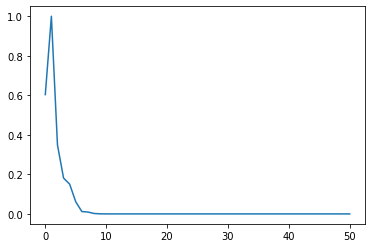

./dk_data/kick/Kawai R-50e-MaxV - R50e Kick 2.wav


In [3]:
#get env feats
PATH_AUDIO=getRandAud()
def envTrans(wf,num_mels=50):
    melEnv=torchaudio.transforms.MelScale(n_mels=2*num_mels, sample_rate=SR, f_min=0.0, f_max=None, n_stft=None)
    wf=wf[:,0:15000]
    num_bins=wf[0].shape[0]//10

    # spec(wf, pad, window, n_fft, hop_length, win_length, power)
    win_length=num_bins
    window=torch.tensor([1]*win_length)
    s=spec(wf, 0, window, num_bins, win_length, win_length,2,normalized=False)
    s=melEnv(s)

    env=s.sum(axis=0).sum(axis=0)
    env=env/env.abs().max()
    env[torch.isnan(env)]=0

    num_padding=torch.max(torch.tensor([num_mels+1-env.shape[0],0]))
    env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
    return env_vec

og_w, sample_rate = torchaudio.load(PATH_AUDIO)  # load tensor from file
wf= ta.transforms.Resample(sample_rate,SR).forward(og_w)

env_feats=envTrans(wf)
plt.plot(env_feats)
plt.show()
print(PATH_AUDIO)
Audio(wf,rate=SR, autoplay=True)

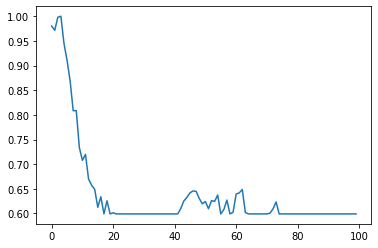

torch.Size([100])
./dk_data/kick/Akai XR10-XR10Kick10.wav


In [4]:
#get freq feats
PATH_AUDIO=getRandAud()
num_mels=100
def freqTrans(wf,num_mels=num_mels):
    ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
    mel=torchaudio.transforms.MelScale(n_mels=num_mels, sample_rate=SR, f_min=0.0, f_max=None, n_stft=None)
    PATH_AUDIO=getRandAud()

#     wf=wf[:,0:2000]
    num_bins=wf[0].shape[0//2]
    win_length=num_bins
    window=torch.tensor([1]*win_length)
    s=spec(wf, 100, window, num_bins, win_length, win_length,2,normalized=False)
    s=mel(s)
    s=ampT(s)
    freq=s.sum(axis=0).sum(axis=1)
    freq=freq/freq.abs().max()
    freq[torch.isnan(freq)]=0
    return freq.detach()

og_w, sample_rate = torchaudio.load(PATH_AUDIO)  # load tensor from file
wf= ta.transforms.Resample(sample_rate,SR).forward(og_w)

freq_feats=freqTrans(wf,num_mels=num_mels)

plt.plot(freq_feats)
plt.show()
print(freq_feats.shape)
print(PATH_AUDIO)
Audio(wf[0:15000],rate=SR, autoplay=True)


In [5]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)
idx=np.random.randint(0,len(ds),5)
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
ds[0]

{'signal': tensor([-0.0003, -0.0019,  0.0305,  ...,  0.0000,  0.0000,  0.0000]),
 'label': tensor(0),
 'path': './dk_data/tom_high/Roland Tr-909-TR-909Tom Hi 01.wav',
 'drum_type': 'tom_high'}

torch.Size([1, 30, 20]) tensor([0.0084, 0.0432, 0.1078, 0.1811, 0.4476, 0.4007, 0.3987, 0.6784, 0.5597,
        0.1460, 0.0385, 0.0218, 0.0557, 0.0721, 0.0418, 0.0298, 0.0290, 0.0190,
        0.0166, 0.0111, 0.0050, 0.0051, 0.0042, 0.0067, 0.0077, 0.0081, 0.0099,
        0.0070, 0.0053, 0.0007])
('tom_high', 0) tensor(0) 44100


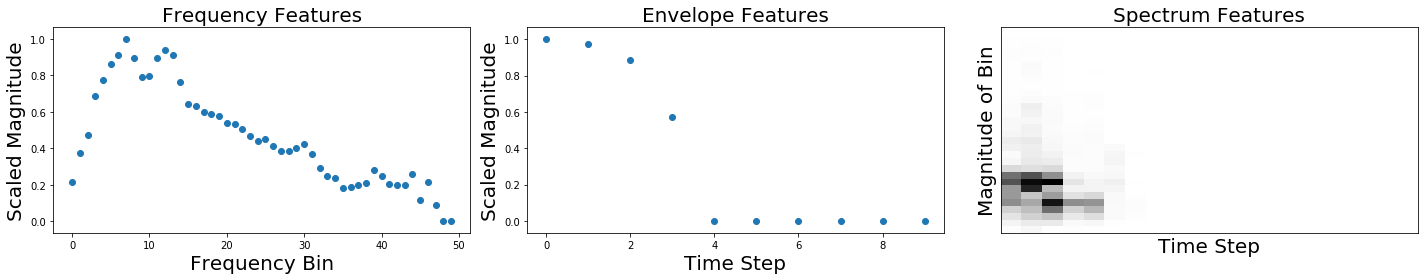

In [511]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
#         s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
#         freq=self.norm(s)
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=16, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0],"path":sample["path"],"drum_type":sample["drum_type"]}
# sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,ft[0,:,0])
        sf=ft.detach().numpy()[0]
        ft=ft.detach().numpy()[0]
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


# SPEC ENCODER

In [512]:
compression_dim=16
spec_dimension=FREQ_BINS*TIME_STEPS
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=256
        )
        self.encoder_output_layer = nn.Linear(
            in_features=256, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=kwargs["input_shape"]
        )
    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        self.encoding=code
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [513]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# H1,H2,H3=100,50,10

# combined_feats=torch.cat((tfList[0](sample)["feats"],tfList[1](sample)["feats"]))


pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
spec_data_train = audioDataset(train,".","dvn", transform=pt)
spec_data_test = audioDataset(test,".",task="dvn", transform=pt)
spec_train_loader= DataLoader(spec_data_train, batch_size=32,shuffle=True, num_workers=16)
spec_test_loader= DataLoader(spec_data_test, batch_size=8,shuffle=True, num_workers=6)

In [514]:

train_synthless=train[train["label_num"]==0]
spec_data_train_nosynth = audioDataset(train,".",task="dvn", transform=pt)
spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=32,shuffle=True, num_workers=16)

In [ ]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=spec_dimension).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# mean-squared error loss
criterion = nn.MSELoss()
epochs=10
for epoch in range(epochs):
    loss = 0
#     for batch_features in spec_train_loader:
    for batch_features in spec_train_nosynth_loader:
        batch_features=batch_features["feats"]

        batch_features = batch_features.view(-1, spec_dimension).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(spec_train_nosynth_loader) 
    
#     display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    if epoch%5==0:
        torch.save(model.state_dict(),'./models/encode/spec_encode_%d_%d_%d.pt'%(compression_dim,epoch,loss,))

epoch : 1/50, loss = 0.012839
epoch : 2/50, loss = 0.012046
epoch : 3/50, loss = 0.011203
epoch : 4/50, loss = 0.010642
epoch : 5/50, loss = 0.010335
epoch : 6/50, loss = 0.010121
epoch : 7/50, loss = 0.009815
epoch : 8/50, loss = 0.009557
epoch : 9/50, loss = 0.009306
epoch : 10/50, loss = 0.009082
epoch : 11/50, loss = 0.008878
epoch : 12/50, loss = 0.008674
epoch : 13/50, loss = 0.008498
epoch : 14/50, loss = 0.008330
epoch : 15/50, loss = 0.008178


In [ ]:
# model = m
dataiter=iter(spec_test_loader)
#does it work?
xy=dataiter.next()
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images=xy["feats"].detach()[0:8]
y=xy["label"].detach()[0:8]
imshow(torchvision.utils.make_grid(images))

print("reconstructed")
image_batch=images.view(-1, spec_dimension).to(device)
recon=model(image_batch).reshape([-1,1,FREQ_BINS,TIME_STEPS]).detach().cpu()
imshow(torchvision.utils.make_grid(recon))

print(y)

In [182]:
#extracting features and putting them into the csv folder for plotting
compression_dim=128
s=torch.load("models/encode/spec_encode_128_20_442.pt")
m = AE(input_shape=spec_dimension**2).to(device)
m.load_state_dict(s)
m.to(device)
i=torch.randn([1,400]).to(device)

encodings=np.empty([1,compression_dim+1])
i=0
d={"feats":[],"label":[],"path":[],"drum_type":[]}
for xy in spec_data_test:
    x=xy["feats"]
    y=xy["label"]
    p=xy["path"]
    drt=xy["drum_type"]
    m(x.view(-1, spec_dimension**2).to(device))
    o=m.encoding.detach().cpu().numpy()
    d["feats"].append(o[0])
    d["label"].append(y.item())
    d["path"].append(p)
    d["drum_type"].append(drt)
    


In [176]:
df=pd.DataFrame.from_dict(d)


,feats,label,path,drum_type
0,"[-0.09613021, 0.14382467, -1.1021733, -0.30146...",0,./dk_data/tom_high/Roland Tr-909-TR-909Tom Hi ...,tom_high
1,"[-0.05657411, 0.4733968, -1.3335822, -0.258143...",0,./dk_data/tom_high/Kawai R50e-R50eTomA_Hi.wav,tom_high
2,"[0.31905425, 0.27743095, -1.1272421, -0.371607...",0,./dk_data/tom_high/Vermona Drum-MaxV - Tom Hi.wav,tom_high
3,"[0.13013196, 0.23643479, -1.3042548, -0.055319...",0,./dk_data/tom_high/Kawai R50-R50 TomH.wav,tom_high
4,"[0.09868078, 0.35649106, -1.1746455, -0.257575...",0,./dk_data/tom_high/Alesis Hr16-MaxV - HR16 10-...,tom_high
...,...,...,...,...
1710,"[-0.22916222, 1.1129311, -1.415165, -1.7518674...",1,./dk_data/synth_noise/UUB9-1770-1.wav,synth_noise
1711,"[-0.0109777935, 1.3970757, -1.610416, -1.39624...",1,./dk_data/synth_noise/ZJXB-238-1.wav,synth_noise
1712,"[-2.8244853, 0.54509467, -2.491179, -1.0516131...",1,./dk_data/synth_noise/838-8-XBHZ.wav,synth_noise
1713,"[-2.0410779, 0.39964476, -2.171807, -0.5160859...",1,./dk_data/synth_noise/NH29-1189-4.wav,synth_noise


In [178]:
# interactive plot to check DVN results
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from plotly.subplots import make_subplots
import pandas as pd
import time
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
import plotly_express as px
import plotly.graph_objs as go
import ipywidgets as widgets
import os
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
n_neighbors = 10

X=df["feats"]

#convert series of arrays into a numpy array
X=pd.DataFrame(X.to_list()).to_numpy()
X = min_max_scaler.fit_transform(X)

time_start = time.time()
# tsne = TSNE(n_components=2, random_state=0, perplexity=80, verbose=1)
tsne = Isomap(n_neighbors, n_components=2)
# tsne = LocallyLinearEmbedding(n_neighbors,n_components=4)
# tsne = SpectralEmbedding(n_neighbors=16,n_components=5,random_state=1)
X_2d = tsne.fit_transform(X)

df2=pd.concat([df["path"],df["drum_type"],pd.Series(X_2d[:,0]),pd.Series(X_2d[:,1])],axis=1)
df2.columns=["path","label","v1","v2"]



In [180]:

p = px.scatter(df2, x="v1",y="v2",color="label",hover_data=["path"],color_discrete_sequence=px.colors.qualitative.G10_r)
for trace in p.data:
    trace.update(hoverinfo="none",hovertemplate= '')
def hover_fn(trace, points, state):
    if points.point_inds:
        ind = points.point_inds[0]
        drmName=trace.customdata[ind][0][2:]
        filename=os.getcwd()+"/"+drmName
#         os.system("play %s trim 0 0.5 &" % filename)
        with open(filename,'rb') as f:
            audio_data = f.read()
        aud.value=audio_data
        
        hover_data.value = str(drmName)+"\n"
        
hover_data = widgets.Textarea()  
aud=widgets.Audio(autoplay=True,blocking=True,loop=False)

layout = go.Layout(hovermode=False,)
fig  = go.FigureWidget(p)
for f in fig.data:
    f.on_hover(hover_fn)


display(fig,widgets.HBox([hover_data]),widgets.HBox([aud]))

FigureWidget({
    'data': [{'customdata': array([['./dk_data/tom_high/Roland Tr-909-TR-909Tom Hi 01.wav'],
  …

In [57]:
from IPython.display import HTML
from base64 import b64encode

filename

'dk_data/hihat_open/Roland System-100-MaxV - Roland -open2 30.wav'

In [144]:
from scipy.io import wavfile
filename="dk_data/hihat_open/Roland System-100-MaxV - Roland -open2 30.wav"

path_to_audio = filename
audio_type = "wav"

sound = open(path_to_audio, "rb").read()



x=Audio(data=sound)
x.reload()
aud2=widgets.Audio(autoplay=True,blocking=True)
aud2.value=sound
aud2

Audio(value=b'RIFF2\xbf\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00D\xac\x00\x00\x88X\x01\x00\x02\x00\x10\…

Type:           Audio
String form:    Audio(value=b'RIFF2\xbf\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00D\xac\x00\x00\x88X\x01\x00\x02\x00\x10\x00d...', loop='False')
File:           ~/miniconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_media.py
Docstring:     
Displays a audio as a widget.

The `value` of this widget accepts a byte string.  The byte string is the
raw audio data that you want the browser to display.  You can explicitly
define the format of the byte string using the `format` trait (which
defaults to "mp3").

If you pass `"url"` to the `"format"` trait, `value` will be interpreted
as a URL as bytes encoded in UTF-8.
Init docstring: Public constructor


# MNIST ENCODER

In [158]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [163]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)
print(len(train_dataset))

60000


In [164]:
# # create a model from `AE` autoencoder class
# # load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs=1
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        print(batch_features.shape)
        batch_features = batch_features.view(-1, 784).to(device)
        print(batch_features.shape)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([

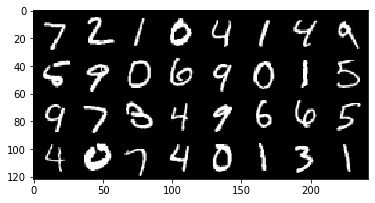

reconstructed


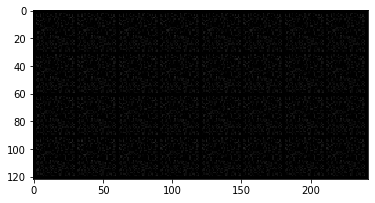

In [161]:
dataiter=iter(test_loader)
# functions to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
    
print("reconstructed")
image_batch=images.view(-1, 784).to(device)
recon=model(image_batch).reshape([32,1,28,28]).detach().cpu()
imshow(torchvision.utils.make_grid(recon))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reconstructed
0


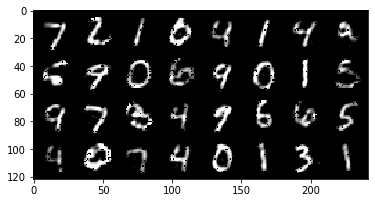

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


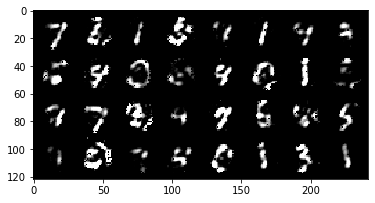

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


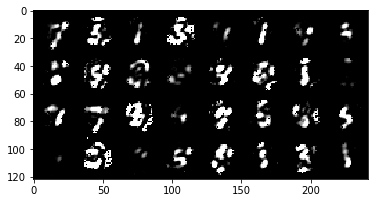

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15


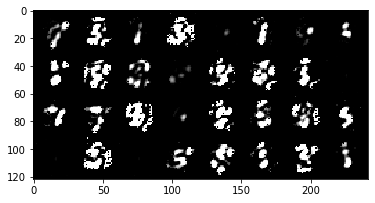

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


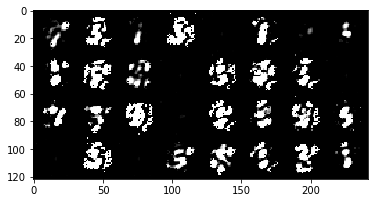

25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


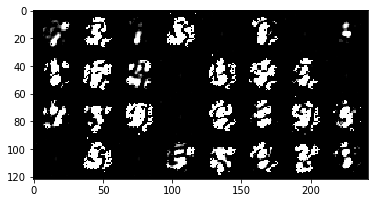

In [64]:
print("reconstructed")
recursed=model(image_batch)
for i in range(30):
    recursed=model(recursed).detach()
    if i%5==0:
        print(i)
        recon=recursed.reshape([32,1,28,28]).detach().cpu()
        imshow(torchvision.utils.make_grid(recon))